# Debugging and sanity checks of f4 ration Nea. estimates

In [1]:
suppressMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
library(devtools)
reload(inst("admixr"))

Reloading installed admixr


In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [86]:
load("../RData/admixtools_debugging.RData")

# Tests on Qiaomei's data

In [4]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

Create a `badsnp` file containing transition SNPs:

In [5]:
read_snp(SNP_FILE) %>% 
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


## Old vs new processing of Altai

In [6]:
old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(old_altai=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(new_altai=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_altai, new_altai, pop)

Joining, by = "name"


Warning message:
“Removed 5 rows containing missing values (geom_point).”

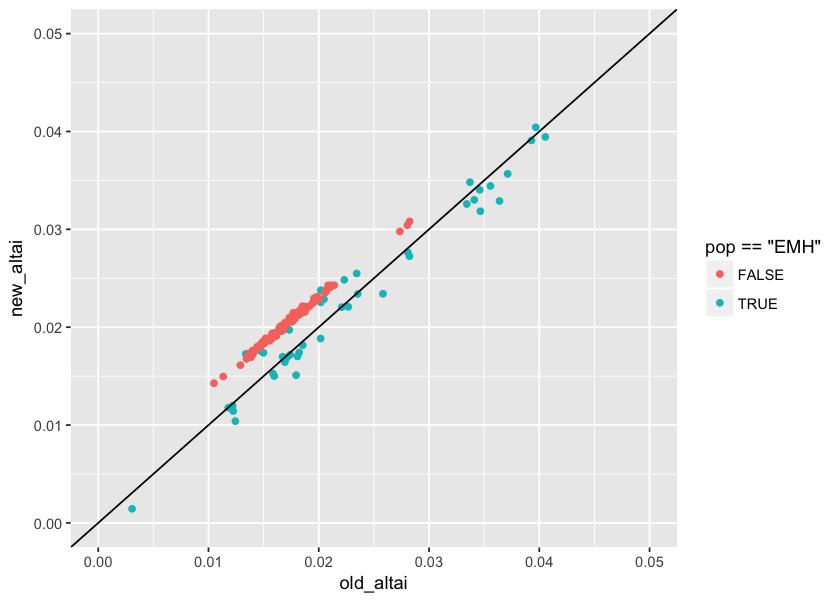

In [7]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(old_vs_new, aes(old_altai, new_altai, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

**TODO** Partition the EMH samples based on their library prep method.

## Old vs new processing of Altai - transversions only

In [8]:
tv_old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(old_tv_only=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(new_tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_tv_only, new_tv_only, pop)

Joining, by = "name"


Warning message:
“Removed 13 rows containing missing values (geom_point).”

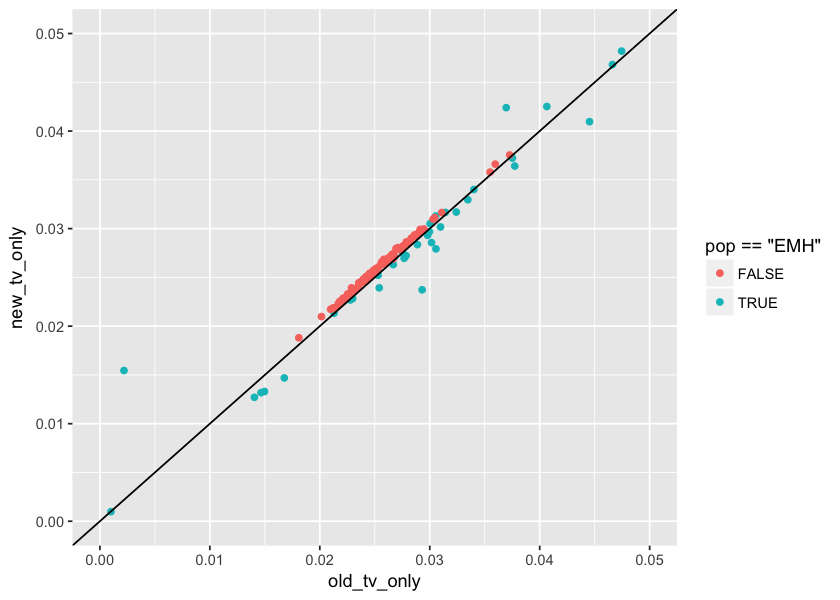

In [9]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(tv_old_vs_new, aes(old_tv_only, new_tv_only, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

The processing of Altai does not matter as long as we restrict to transversions only. Compare this to the previous plot, where there was a big difference in old vs new Altai processing.

This indicates that it really is a different way of calling genotypes in Altai vs Vindija that messes up things in the f4 ratio calculation.

## new Altai - Transversions-only vs all SNPs

In [10]:
tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


## Transversions-only vs all SNPs

In [12]:
old_tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


Obviously, since TV-only results are perfectly correlated between old and new processing, this result looks the same as the one directly above.

## Does "manual" f4 calculation result in the same thing as `qpF4ratio` estimate?

#### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [14]:
num <- qpDstat(W=filter(samples, pop == "WestEurasia")$name, X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [15]:
den <- qpDstat(W="new_Vindija", X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [16]:
two_f4 <- mutate(num, alpha=Dstat/den$Dstat) %>% rename(two_f4=alpha)

#### Calculate the f4 ratios on the same set of samples

In [17]:
f4_ratio <- qpF4ratio(X=filter(samples, pop == "WestEurasia")$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                      prefix=EIGENSTRAT) %>%
    rename(f4_ratio=alpha)

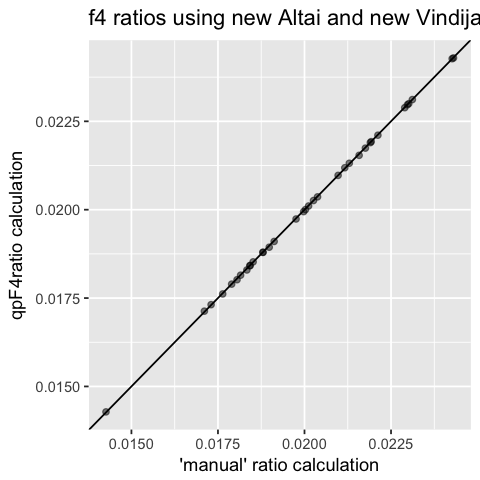

In [18]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(two_f4, f4_ratio, by=c("W"="X")) %>%
ggplot(aes(two_f4,  f4_ratio)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="'manual' ratio calculation", y="qpF4ratio calculation")

Both approaches give exactly the same result (as expected). So I can use the individual f4 for debugging purposes.

<br><br><br>
# My f4 ratios on Qiaomei's dataset vs Steffi's f4 ratios on her dataset

Load Steffi's results:

In [19]:
suppressMessages({
    
steffi_df <- bind_rows(
    read_table2("../raw_data/steffi/results_usti_test/f4_ratios") %>% mutate(set="steffi_f4_vcf_all"),
    read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="steffi_f4_vcf_intersect")
    ) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

steffi_f4 <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio)

})

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her whole VCF

In [394]:
my_f4_qiaomei_all <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                         prefix=EIGENSTRAT) %>% rename(my_f4_qiaomei_all=alpha)

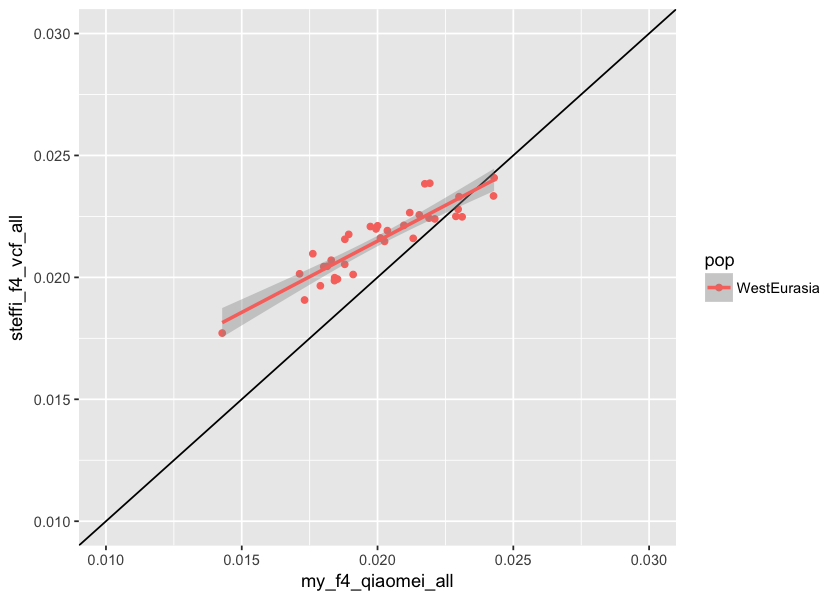

In [395]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her VCF intersect (~250k of sites)

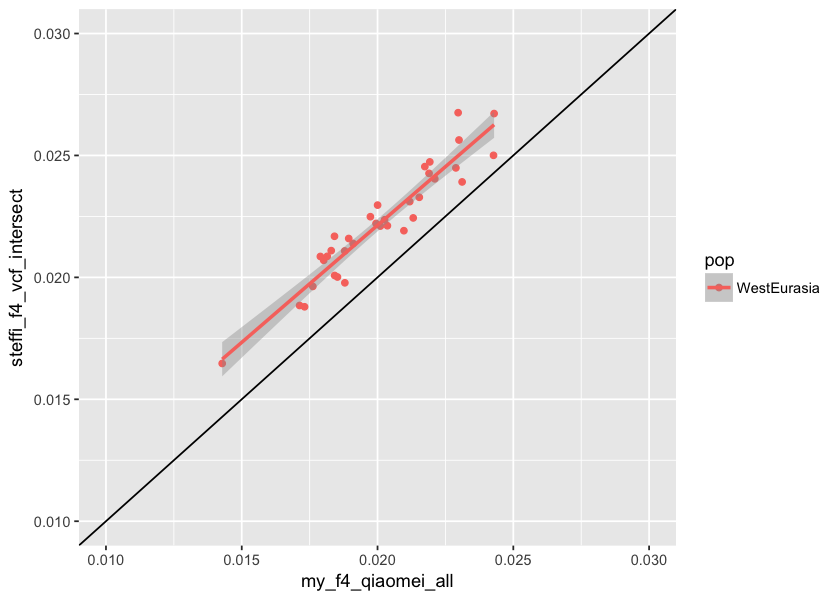

In [22]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Steffi's 250k sites VCF subset vs Steffi's f4 on the same data

This uses the same data (EIGENSTRAT generated from VCF and the VCF itself).

**Any potential difference is caused by the computation of Admixtools vs Steffi's script.**

In [23]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
STEFFI_EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "steffi")

STEFFI_EIGENSTRAT_INTERSECT <- paste0(STEFFI_EIGENSTRAT, "_intersect")

In [28]:
suppressMessages(
    subset_sites(STEFFI_EIGENSTRAT, STEFFI_EIGENSTRAT_INTERSECT, pos_file="../raw_data/eigenstrat_all/sites.pos")
)

[1] TRUE

In [398]:
my_f4_vcf_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=STEFFI_EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_vcf_intersect=alpha)

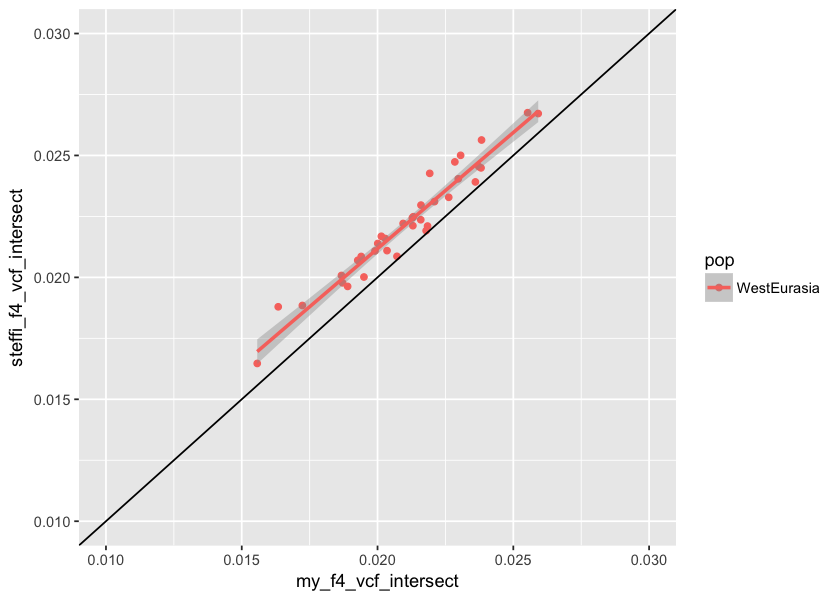

In [30]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

Both sets were calculated on the same data, but one using Admixtools (x axis) and another using Steffi's scripts (y axis).

**This must reflect some difference in the f4 calculation.** Steffi calculates both f4 numerator and denominator separately and then divides them. Could this be part of an explanation?

I will have to calculate individual ABBA/BABA counts using Admixtools to see if that is the case.

## My f4 on 250k subset of Qiaomei's data vs my f4 on subset of Steffi's VCF (~250k sites)

What happens if we subset even Qiaomei's EIGENSTRAT dataset to the same set of sites that remain in Steffi's VCF after intersecting?

Is there a difference in data processing?

In [401]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

EIGENSTRAT_INTERSECT <- paste0(EIGENSTRAT, "_intersect")

In [32]:
suppressMessages(
    subset_sites(EIGENSTRAT, EIGENSTRAT_INTERSECT, pos_file="../raw_data/merged_vcfs/sites.pos")
)

[1] TRUE

In [402]:
my_f4_qiaomei_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_qiaomei_intersect=alpha)

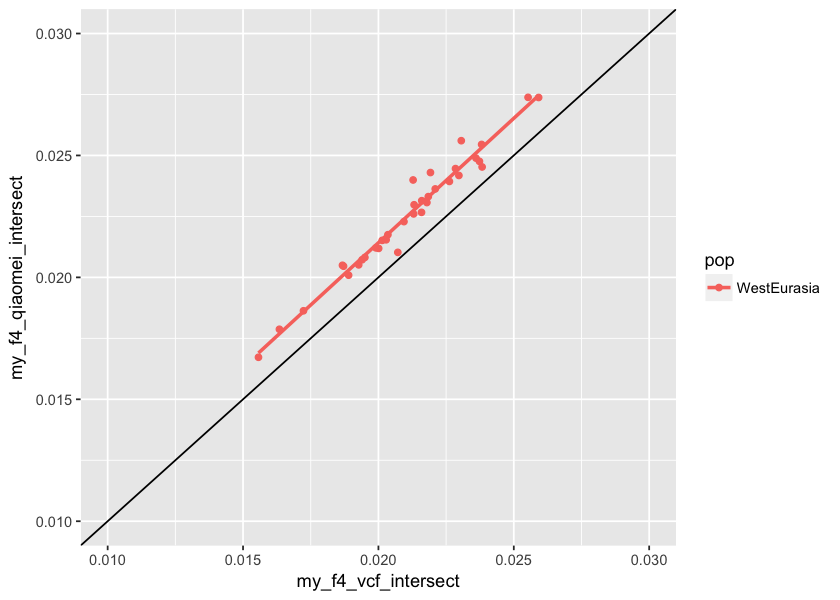

In [34]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

This is strange. So the "Any potential difference is caused by the computation of Admixtools vs Steffi's script." is not correct?

Huh, both my f4 on subset of Qiaomei's data and Steffi's f4 on her subset of her VCF are higher than my f4 on the VCF subset.

## My f4 on 250k sites from Qiaomei's data vs Steffi's 250k intersect on her data

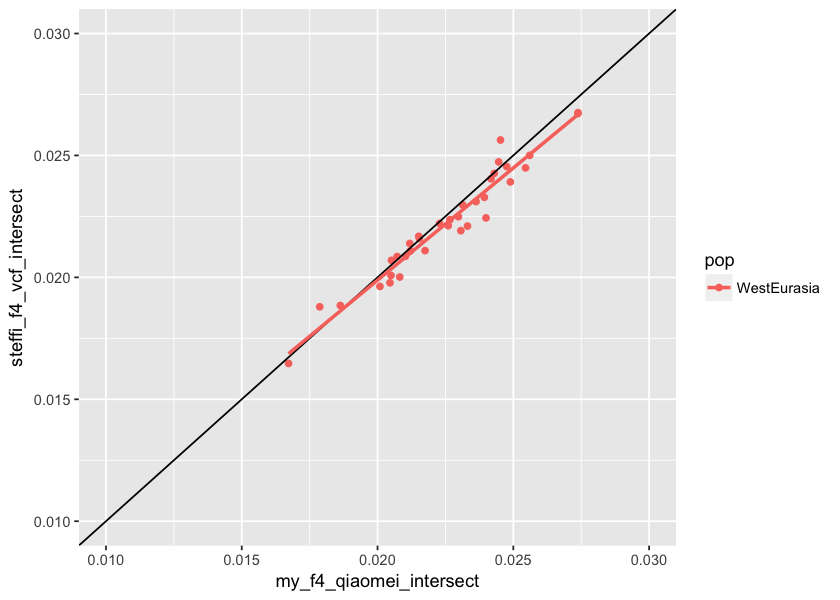

In [36]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_intersect, steffi_f4, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_intersect, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## All sites vs subset on Steffi's data, also using Qiaomei's data

In [37]:
my_f4_vcf_all <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                           prefix=STEFFI_EIGENSTRAT) %>% 
    rename(my_f4_vcf_all=alpha)

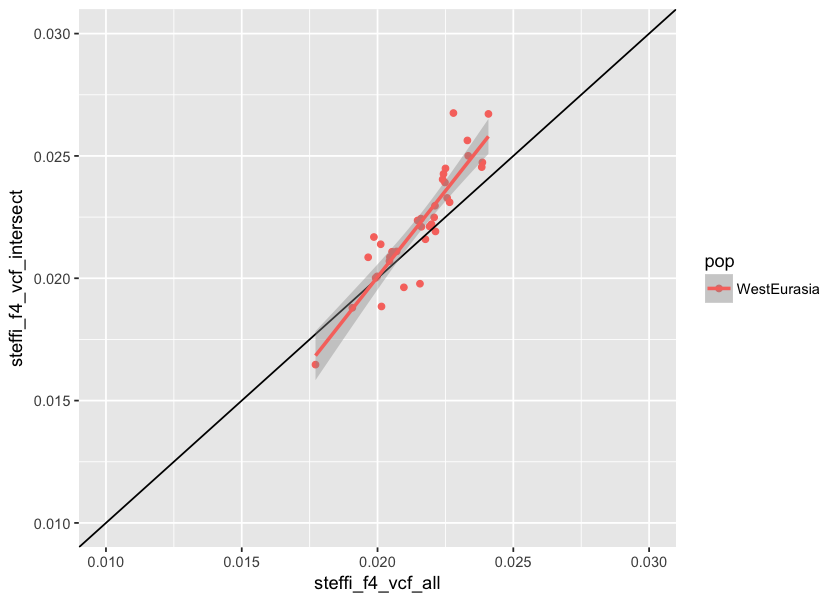

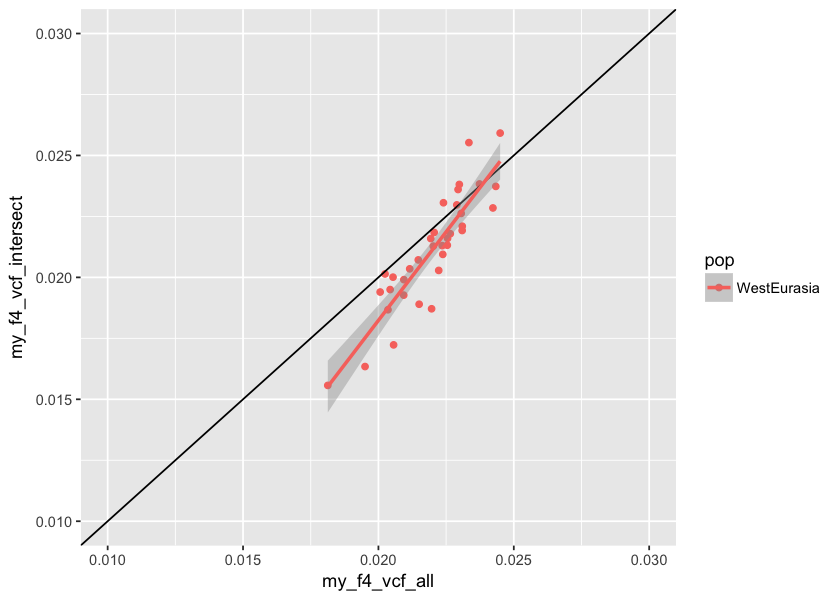

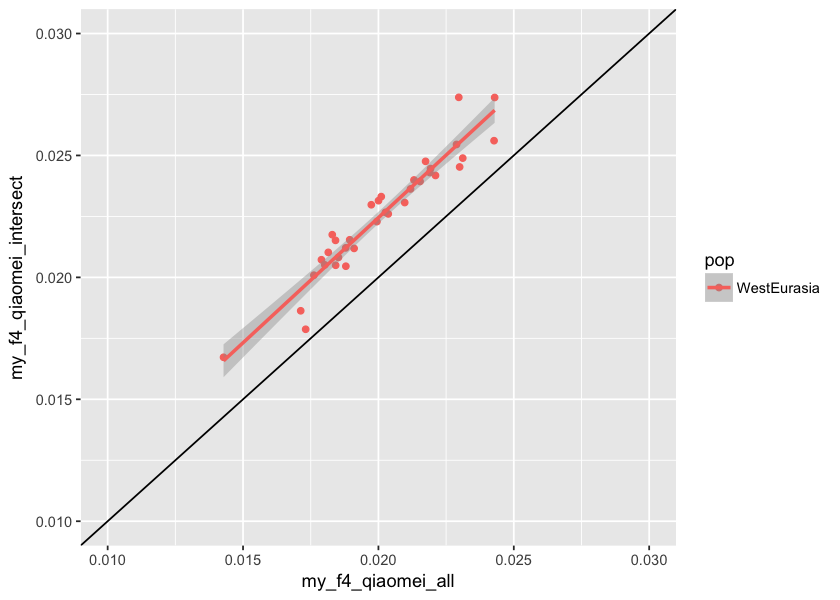

In [87]:
options(repr.plot.width=7, repr.plot.height=5)

options(repr.plot.width=7, repr.plot.height=5)

steffi_f4 %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(steffi_f4_vcf_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_all, my_f4_vcf_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_vcf_all, my_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

inner_join(my_f4_qiaomei_all, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_qiaomei_all, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

# Investigating the case of the nearly perfect correlation

The fact that the f4 results line up when I estimate f4 using Admixtools on Qiaomei's data and when Steffi estimates f4 on her data suggests there might be a difference in both the actual calcuation and in the data processing as well. Let's look into both of these options.

## ABBA and BABA counts

#### my stuff

In [408]:
martin_f4_qiaomei_intersect <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=EIGENSTRAT_INTERSECT, f4mode=TRUE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_qiaomei_intersect")

martin_f4_vcf_intersect <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=STEFFI_EIGENSTRAT_INTERSECT, f4mode=TRUE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_vcf_intersect")

#### Steffi's stuff

In [409]:
steffi_f4_ratios_intersect <- filter(steffi_df, pop3 == "Altai", pop2 == "Mbuti", set == "steffi_f4_vcf_intersect") %>%
    filter(name %in% c("Vindija", filter(samples, pop == "WestEurasia")$name)) %>%
    mutate(name=ifelse(name == "Vindija", "new_Vindija", name)) %>% 
    select(name, ABBA=abba, BABA=baba, f4, f4_ratio, z) %>%
    mutate(what="steffi_vcf_intersect")

steffi_f4_ratios_all <- filter(steffi_df, pop3 == "Altai", pop2 == "Mbuti", set == "steffi_f4_vcf_all") %>%
    filter(name %in% c("Vindija", filter(samples, pop == "WestEurasia")$name)) %>%
    mutate(name=ifelse(name == "Vindija", "new_Vindija", name)) %>% 
    select(name, ABBA=abba, BABA=baba, f4, f4_ratio, z) %>%
    mutate(what="steffi_vcf_all")

#### comparisons

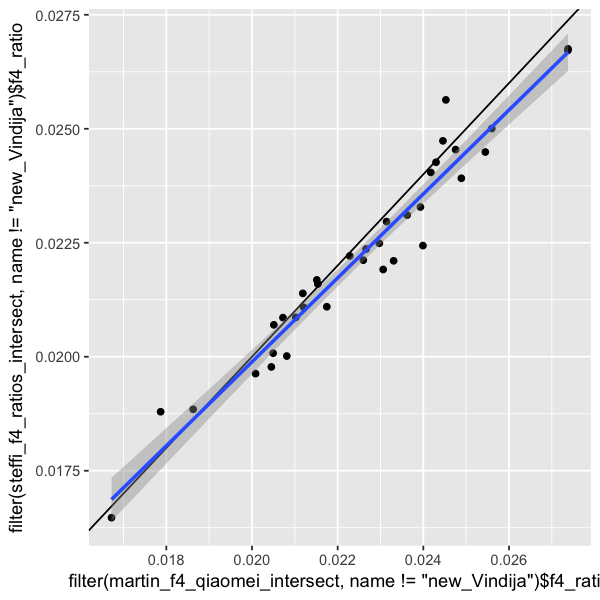

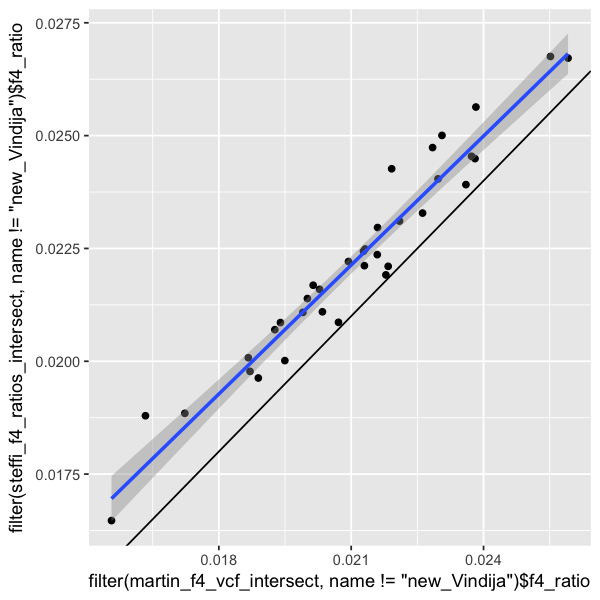

In [413]:
options(repr.plot.width=5, repr.plot.height=5)

qplot(filter(martin_f4_qiaomei_intersect, name != "new_Vindija")$f4_ratio,
      filter(steffi_f4_ratios_intersect, name != "new_Vindija")$f4_ratio) +
    geom_abline(slope=1) +
    geom_smooth(method="lm")

options(repr.plot.width=5, repr.plot.height=5)

qplot(filter(martin_f4_vcf_intersect, name != "new_Vindija")$f4_ratio,
      filter(steffi_f4_ratios_intersect, name != "new_Vindija")$f4_ratio) +
    geom_abline(slope=1) +
    geom_smooth(method="lm")

Warning message:
“Removed 3 rows containing missing values (geom_point).”

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

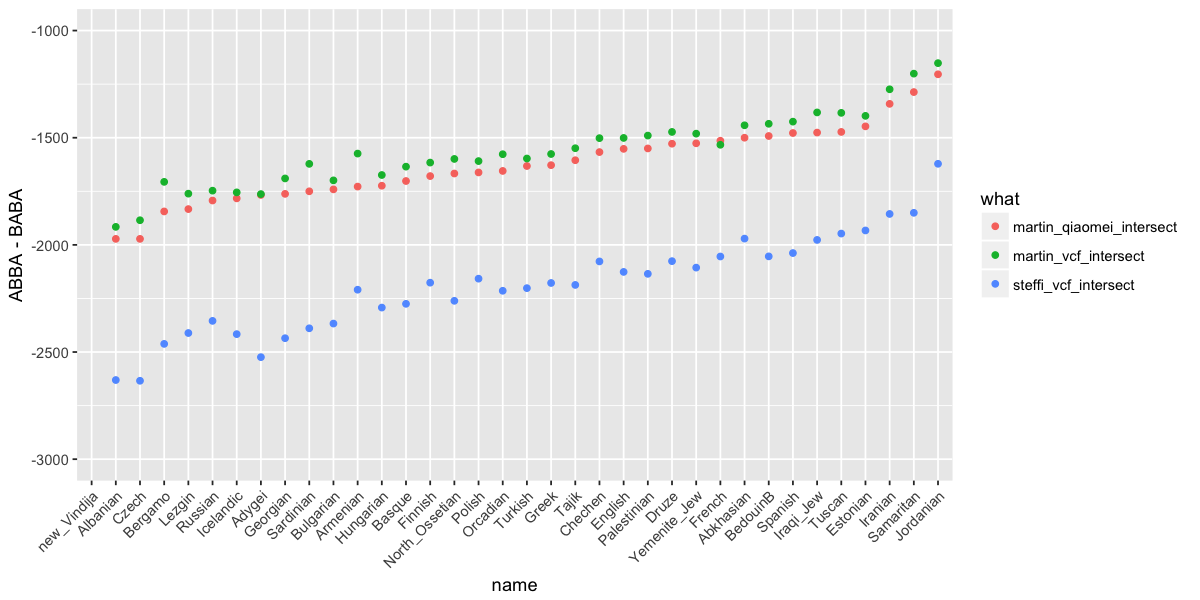

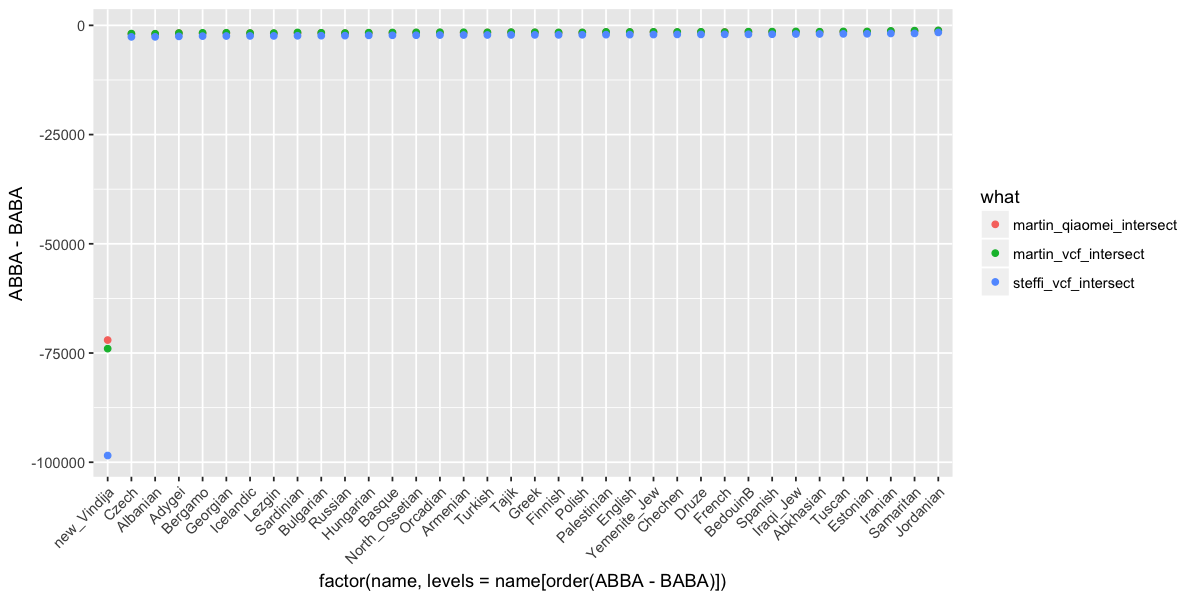

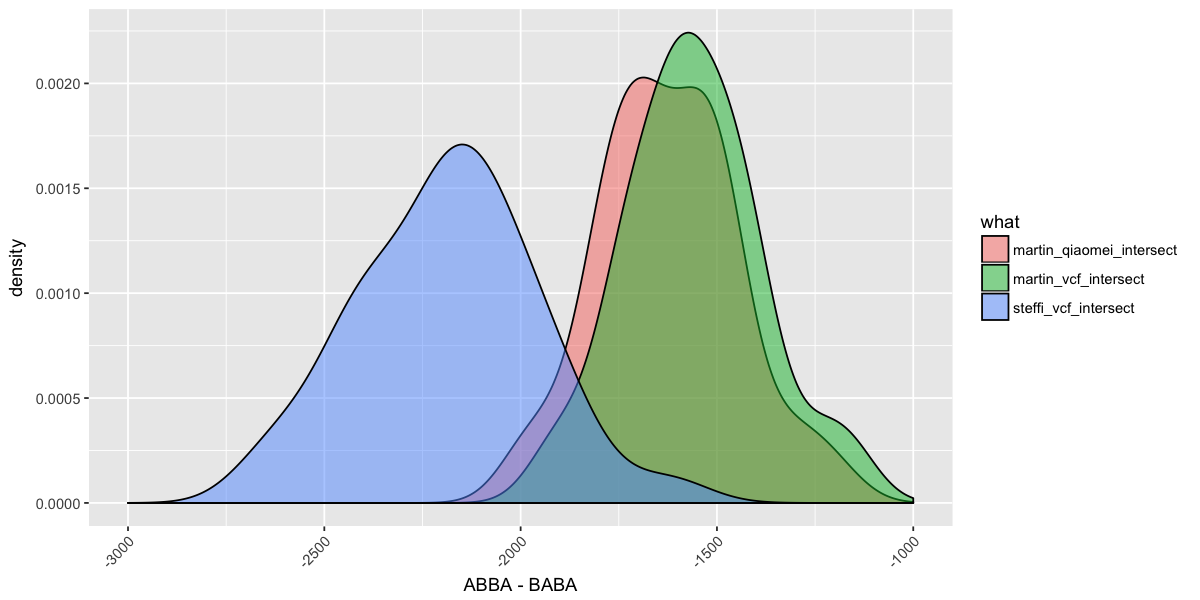

In [417]:
options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
mutate(name=factor(name, levels=name[order(martin_f4_qiaomei_intersect$ABBA - martin_f4_qiaomei_intersect$BABA)])) %>% 
ggplot(aes(name, ABBA-BABA, color=what)) +
    geom_point() +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ylim(-3000, -1000)

options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
mutate(name=factor(name, levels=name[order(martin_f4_qiaomei_intersect$ABBA - martin_f4_qiaomei_intersect$BABA)])) %>% 
ggplot(aes(factor(name, levels=name[order(ABBA-BABA)]), ABBA-BABA, color=what)) +
    geom_point() +
    theme(axis.text.x=element_text(angle=45, hjust=1))

options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
filter(!str_detect(name, "new_Vindija")) %>% 
ggplot(aes(ABBA-BABA, fill=what)) +
    geom_density(alpha=1/2) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    xlim(-3000, -1000)

<font color="red">Steffi's calculation has a higher number of BABA sites than ABBA sites?</font>

In [591]:
save.image("../RData/admixtools_debugging.RData")

In [606]:
qiaomei_geno <- read_geno(paste0(EIGENSTRAT_INTERSECT, ".geno"), paste0(EIGENSTRAT_INTERSECT, ".ind"))
vcf_geno <- read_geno(paste0(STEFFI_EIGENSTRAT_INTERSECT, ".geno"), paste0(STEFFI_EIGENSTRAT_INTERSECT, ".ind"))

Parsed with column specification:
cols(
  id = col_character(),
  sex = col_character(),
  label = col_character()
)
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  id = col_character(),
  sex = col_character(),
  label = col_character()
)
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


In [607]:
qiaomei_geno <- select(qiaomei_geno, one_of(intersect(names(qiaomei_geno), names(vcf_geno)))) %>%
    bind_cols(read_snp(paste0(EIGENSTRAT_INTERSECT, ".snp")), .) %>%
    select(-id, -gen)

vcf_geno <- select(vcf_geno, one_of(intersect(names(qiaomei_geno), names(vcf_geno)))) %>%
    bind_cols(read_snp(paste0(STEFFI_EIGENSTRAT_INTERSECT, ".snp")), .) %>%
    select(-id, -gen)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)
Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_integer(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


In [609]:
table(qiaomei_geno$new_Vindija, vcf_geno$new_Vindija)
table(qiaomei_geno$new_Altai,   vcf_geno$new_Altai)

   
         0      1      2
  0 108052      0      0
  1      0  15118      0
  2      0      0 130999

   
         0      1      2
  0  99383      0      0
  1      0  38777      0
  2      0      0 116009

In [629]:
mismatch_gt <- function(ind) {
    mismatch_pos <- qiaomei_geno[[ind]] != vcf_geno[[ind]]
    print(table(qiaomei_geno[[ind]], vcf_geno[[ind]]))
    
    mismatches <- bind_cols(
        select(qiaomei_geno, chrom, pos, ref_qiaomei=ref, alt_qiaomei=alt)[mismatch_pos, ],
        select(vcf_geno, ref_steffi=ref, alt_steffi=alt)[mismatch_pos, ],
        setNames(qiaomei_geno[mismatch_pos, ind], "qiaomei"),
        setNames(vcf_geno[mismatch_pos, ind], "vcf")
    ) %>% filter(qiaomei != 9 & vcf != 9)
    
    print(table(qiaomei_geno[!mismatch_pos, ][[ind]], vcf_geno[!mismatch_pos, ][[ind]]))
    
    mismatches
}

In [631]:
mismatch_gt("S_French-1") %>% head

   
         0      1      2      9
  0  42520      0    822    225
  1      8  61559     16    375
  2     84      7 147938    592
  9      1      8      7      7
   
         0      1      2      9
  0  42520      0      0      0
  1      0  61559      0      0
  2      0      0 147938      0
  9      0      0      0      7


chrom,pos,ref_qiaomei,alt_qiaomei,ref_steffi,alt_steffi,qiaomei,vcf
1,4673937,C,T,T,C,0,2
1,10922579,C,T,T,C,0,2
1,14804654,A,G,G,A,0,2
1,20613458,C,T,T,C,0,2
1,30225125,C,A,A,C,0,2
1,35094871,G,A,A,G,0,2


## Does the shift in f4 vs f4 scatterplots correspond to the excess of "false ALTs"?
## Do I get a diagonal matrix using `table` on X when I filter those "flipped" sites in an individual X?